making catalogues to test within eazy
opens ZFOURGE cat file, prepares it for dataframe, and some different catalogues are made (binning and such)
then these are saved and can be used within the eazy code
Best to run this as separate cells, specified to your requirements

In [1]:
%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import time
import importlib
import sys
import eazy
import astropy.stats

output = 'inputs/alternate_catalogues/'

In [6]:
# Adapting Template Files for EAZY

# Set the directory
in_dir = 'G:/AGN/hlsp_agnsedatlas_multi_multi_all_multi_v1_collection/templates_restframe/'
#out_dir = 'C:/Users/eddie/PycharmProjects/SEDTemplate_conda/templates/hlsp_agnsedatlas_rest/'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Get the txt files  in the directory
txt_files = glob.glob(in_dir + '*.txt')

#txt_files = [i for i in txt_files if 'central' in i] # If you want the composite files

for i in txt_files:

    # Read the txt file
    data = pd.read_csv(i, sep=" ", comment='#', header=None, skipinitialspace=True)

    data[0] = data[0] * 1e4 # Convert the wavelength from Micron to Angstroms
    output_data = data[[0,2]]

    # Get the base name of the txt file
    base_name = os.path.basename(os.path.splitext(i)[0])

    # Write the selected data to a dat file
    output_data.to_csv(out_dir + f'{base_name}.dat', sep=' ', index=False, header=False)


In [104]:
# Making any combined catalogues that cross multiple fields

fields  = ['cdfs', 'cosmos', 'uds']

main_dir_combined = []
main_combined_all = []
translate_all = []

for idx, field in enumerate(fields):
    all_catalogues = glob.glob(f'zfourge/{field}/{field}*.cat')

        # Check if any files were found
    if not all_catalogues:
      print(f"No .cat files found for {field}")
    else:
      # Find the shortest file by filename
      main_dir_combined.append(min(all_catalogues, key=len))

    main = pd.read_csv(main_dir_combined[idx], sep=" ", comment="#", header=None)
    headers = pd.read_csv(main_dir_combined[idx], sep=" ", header=None, nrows=1).iloc[0]
    headers = headers[1:]
    main.columns = headers

    agn_data1 = glob.glob(f'zfourge/{field}/{field}.v*.agn.*cat') # This is the agn file
    agn = pd.read_csv(agn_data1[0], sep="\s+", comment='#', header=None)
    headers = ['id', 'ir_agn', 'radio_agn','xray_agn']
    agn.columns = headers


    merged = pd.merge(main, agn, on='id', how='left')
    unwanted_hash = pd.Series(np.nan, index=merged.index, dtype=float)
    merged.insert(loc=0, column='#', value=unwanted_hash) #wierd hash at the start

    main_combined_all.append(merged)

    # Also need to make a new translate file
    translate_file = glob.glob(f'zfourge/{field}/eazy/{field}.*.translate') # again this glob function will need some customisation
    translate = pd.read_csv(translate_file[0], sep='\s+', header=None, usecols=range(2))
    translate_all.append(translate)

main_combined = pd.concat(main_combined_all, ignore_index=True)
main_combined['id'] = main_combined.index + 1

translate_final = pd.concat(translate_all, ignore_index=True)
translate_final = translate_final.drop_duplicates(keep='first')

In [103]:

if not os.path.isdir('zfourge/combined/eazy'):
    os.makedirs('zfourge/combined/eazy')

translate_final.to_csv('zfourge/combined/eazy/combined.1.0.translate', sep=' ', index=False)

In [105]:
# Columns to exclude
exclude_cols = ['#']
# Replace NaN with -99 for all columns except excluded columns
main_combined.loc[:, ~main_combined.columns.isin(exclude_cols)] = main_combined.loc[:, ~main_combined.columns.isin(exclude_cols)].fillna(-99)

# move agn columns to the end so that nan values are not in the middle of the file
agn_cols = ['star', 'nearstar', 'use', 'snr', 'use_nosnr', 'z_spec', 'ir_agn', 'radio_agn', 'xray_agn']

main_combined = main_combined[[col for col in main_combined if col not in agn_cols] + [col for col in agn_cols]]
main_combined.to_csv(f'{output}combined.normal.cat', sep=' ', index=False)

## Start here if you have made the combined catalogue

In [6]:
# Load the catalogues

os.getcwd()

field = 'uds'

# Get all cat files
all_files = glob.glob(f'zfourge/{field}/{field}*.cat')

# Check if any files were found
if not all_files:
  print("No .cat files found")
else:
  # Find the shortest file by filename
  main_dir = min(all_files, key=len)

main = pd.read_csv(main_dir, sep=" ", comment="#", header=None)
headers = pd.read_csv(main_dir, sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
main.columns = headers

agn_data1 = glob.glob(f'zfourge/{field}/{field}.v*.agn.*cat')
agn = pd.read_csv(agn_data1[0], sep="\s+", comment='#', header=None)
headers = ['id', 'ir_agn', 'radio_agn','xray_agn']
agn.columns = headers


merged = pd.merge(main, agn, on='id', how='left')
unwanted_hash = pd.Series(np.nan, index=merged.index, dtype=float)
merged.insert(loc=0, column='#', value=unwanted_hash) #wierd hash at the start

Saving the Catalogue file

In [76]:
merged.to_csv(f'{output}{field}.normal.cat', sep=' ', index=False)

In [8]:
useflag_df  = merged[merged['use'] == 1]
useflag_df.to_csv(f'{output}{field}.useflag.cat', sep=' ', index=False)
print(f'the size of this dataframe is: '{len(useflag_df)})

13299


Doing Specific Range Cuts

In [59]:
object_range = (0,-0)
new_cat = merged[object_range[0]:object_range[1]]
new_cat.to_csv(f'{output}{field}.range.{object_range}.cat', sep=' ', index=False)

Doing Standard AGN Type Cuts, AGN type (Or wavelength) is not really as useful as the fraction of AGN

In [16]:
# ir_cut = merged[(merged['ir_agn'] == 1) & (merged['z_spec'] > 0)]
# radio_cut = merged[(merged['radio_agn'] == 1) & (merged['z_spec'] > 0)]
# xray_cut = merged[(merged['xray_agn'] == 1) & (merged['z_spec'] > 0)]
# all_cut = merged[(merged['ir_agn'] == 1) & (merged['z_spec'] > 0) | (merged['radio_agn'] == 1) & (merged['z_spec'] > 0) | (merged['xray_agn'] == 1) & (merged['z_spec'] > 0)]
# nothing_cut = merged[(merged['ir_agn'] != 1) & (merged['radio_agn'] != 1) & (merged['xray_agn'] != 1) & (merged['z_spec'] > 0)]

ir_cut = merged[(merged['ir_agn'] == 1)]
radio_cut = merged[(merged['radio_agn'] == 1)]
xray_cut = merged[(merged['xray_agn'] == 1)]
all_cut = merged[(merged['ir_agn'] == 1) | (merged['radio_agn'] == 1) | (merged['xray_agn'] == 1)]
nothing_cut = merged[(merged['ir_agn'] != 1) & (merged['radio_agn'] != 1) & (merged['xray_agn'] != 1)]

ir_cut.to_csv(f'{output}{field}.ir_agn.cat', sep=' ', index=False)
radio_cut.to_csv(f'{output}{field}.radio_agn.cat', sep=' ', index=False)
xray_cut.to_csv(f'{output}{field}.xray_agn.cat', sep=' ', index=False)
all_cut.to_csv(f'{output}{field}.all_agn.cat', sep=' ', index=False)
nothing_cut.to_csv(f'{output}{field}.no_agn.cat', sep=' ', index=False)

Reading the AGN Fraction file, and slimming it down, and creating keys from it

In [11]:
# Read the CIGALE results file
agn_per_dir = f'inputs/{field}_results.txt' # large file
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

In [12]:
new_bayes = all_bayes[['id', 'bayes.agn.fracAGN', 'bayes.agn.fracAGN_err', 'bayes.agn.luminosity']] # this is the information I want from this file
new_bayes.to_csv(f'inputs/{field}_agn_frac.txt', sep=' ', index=False)

In [87]:
#making combined bayes file
all_agn_data = []
for field in fields:
    agn_data = pd.read_csv(f'inputs/{field}_agn_frac.txt', sep="\s+", comment='#')
    all_agn_data.append(agn_data)

all_agn_data = pd.concat(all_agn_data, ignore_index=True)
all_agn_data['id'] = all_agn_data.index + 1
all_agn_data.to_csv(f'inputs/combined_agn_frac.txt', sep=' ', index=False)

Merging the AGN fraction file with the main catalogue

In [7]:
bayes = pd.read_csv(f'inputs/{field}_agn_frac.txt', sep="\s+", comment='#')
merged_bayes = pd.merge(merged, bayes, on='id', how='left')
fraction_sorted = merged_bayes.sort_values(by='bayes.agn.fracAGN', ascending=False)
luminosity_sorted = merged_bayes.sort_values(by='bayes.agn.luminosity', ascending=False)
num_rows = merged_bayes.shape[0]

AGN Bins, usually have 10 bins

In [8]:
num_bins = 10
fraction_range = 100/num_bins

#split fraction sorted into bins and save each as a separate df

for bin_no in range(num_bins):
    min_bin = (bin_no * fraction_range) / 100
    max_bin = ((bin_no+1) * fraction_range) / 100
    bin_df = fraction_sorted[(min_bin <= fraction_sorted['bayes.agn.fracAGN']) &
                             (fraction_sorted['bayes.agn.fracAGN'] <= max_bin)]
    bin_df.to_csv(f'{output}{field}.fraction.bin{min_bin}to{max_bin}.cat', sep=' ', index=False)



In [9]:
#Only objects with an agn fraction above percent
percent = 0.50
only_agn = merged_bayes[merged_bayes['bayes.agn.fracAGN'] >= percent]
print(len(only_agn))
only_agn.to_csv(f'{output}{field}.only_agn_above_{percent}.cat', sep=' ', index=False)

2958


## Lacy wedge

In [76]:
# set field again
is_it_combined = False
if is_it_combined:
    lacy_init_df = main_combined[['f_IRAC_58', 'e_IRAC_58', 'f_IRAC_36', 'e_IRAC_36', 'f_IRAC_80', 'e_IRAC_80', 'f_IRAC_45', 'e_IRAC_45', 'bayes.agn.fracAGN']]
else:
    lacy_init_df = merged_bayes[['f_IRAC_58', 'e_IRAC_58', 'f_IRAC_36', 'e_IRAC_36', 'f_IRAC_80', 'e_IRAC_80', 'f_IRAC_45', 'e_IRAC_45', 'bayes.agn.fracAGN']]
cut_by_negative_lacy = (lacy_init_df['f_IRAC_58'] > -0) &\
                       (lacy_init_df['f_IRAC_36'] > -0) &\
                       (lacy_init_df['f_IRAC_80'] > -0) &\
                       (lacy_init_df['f_IRAC_45'] > -0)
lacy_init_df = lacy_init_df[cut_by_negative_lacy]

cut_by_error_lacy = (lacy_init_df['f_IRAC_58'] > 3 * lacy_init_df['e_IRAC_58']) &\
                    (lacy_init_df['f_IRAC_36'] > 3 * lacy_init_df['e_IRAC_36']) &\
                    (lacy_init_df['f_IRAC_80'] > 3 * lacy_init_df['e_IRAC_80']) &\
                    (lacy_init_df['f_IRAC_45'] > 3 * lacy_init_df['e_IRAC_45'])

#lacy_init_df = lacy_init_df[cut_by_error_lacy]

In [77]:
lacy_df = pd.DataFrame()
lacy_df['58'] = lacy_init_df['f_IRAC_58']
lacy_df['36'] = lacy_init_df['f_IRAC_36']
lacy_df['80'] = lacy_init_df['f_IRAC_80']
lacy_df['45'] = lacy_init_df['f_IRAC_45']
lacy_df['agn'] = lacy_init_df['bayes.agn.fracAGN']

lacy_df['x'] = np.log10(lacy_df['58']/lacy_df['36'])
lacy_df['y'] = np.log10(lacy_df['80']/lacy_df['45'])

cut = (lacy_df['x'] > -0.1) & (-0.2 < lacy_df['y']) & (lacy_df['y'] < (0.8 * lacy_df['x'] + 0.5))
lacy_in = lacy_df[cut]
lacy_out = lacy_df[~cut]

common_index = merged.index.intersection(lacy_in.index)
lacy_cat = merged.loc[common_index]

#lacy_cat.to_csv(f'{output}{field}.lacy_wedge.cat', sep=' ', index=False)

(-1.2, 1.2)

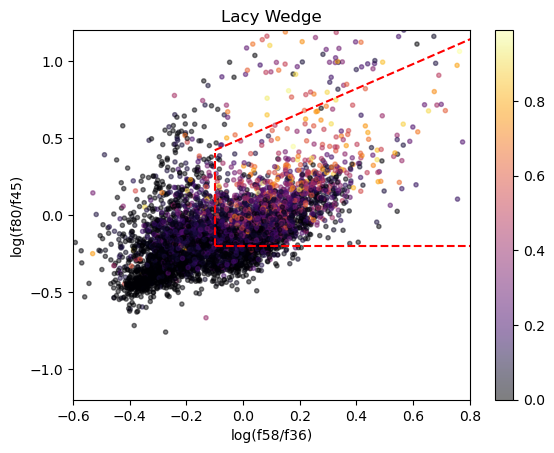

In [69]:
plt.scatter(lacy_in['x'], lacy_in['y'], c=lacy_in['agn'], cmap='inferno', marker='.', alpha=0.5)
plt.scatter(lacy_out['x'], lacy_out['y'], c=lacy_out['agn'], cmap='inferno', marker='.', alpha=0.5)

x_boundary = np.linspace(-0.1, 2, 100)  # Adjust range as needed
y_boundary1 = -0.2 * np.ones_like(x_boundary)
y_boundary2 = 0.8 * x_boundary + 0.5
y_line = np.linspace(-0.2, 0.4, 100)
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('Lacy Wedge')
plt.colorbar()
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)

In [59]:
cut_donley = (lacy_df['x'] >= 0.08) & (lacy_df['y'] >= 0.15) & (lacy_df['y'] >= (1.21 * lacy_df['x']) - 0.27) & (lacy_df['y'] <= (1.21 * lacy_df['x']) + 0.27) & (lacy_df['80'] > lacy_df['58']) & (lacy_df['58'] > lacy_df['45']) & (lacy_df['45'] > lacy_df['36'])

donley_in = lacy_df[cut_donley]
donley_out = lacy_df[~cut_donley]

common_index = merged.index.intersection(donley_in.index)
lacy_cat = merged.loc[common_index]
#lacy_cat.to_csv(f'{output}{field}.donley_wedge.cat', sep=' ', index=False)

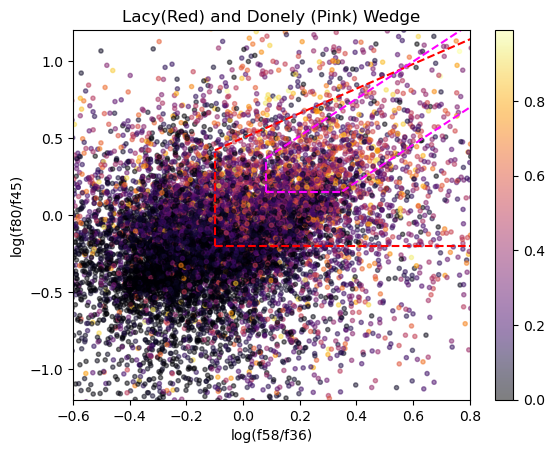

In [60]:
plt.scatter(donley_in['x'], donley_in['y'], c=donley_in['agn'], cmap='inferno', marker='.', alpha=0.5)
plt.scatter(donley_out['x'], donley_out['y'], c=donley_out['agn'], cmap='inferno', marker='.', alpha=0.5)

x_boundary = np.linspace(-0.1, 2, 100)  # Adjust range as needed
y_boundary1 = -0.2 * np.ones_like(x_boundary)
y_boundary2 = 0.8 * x_boundary + 0.5
y_line = np.linspace(-0.2, 0.4, 100)
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('Lacy(Red) and Donely (Pink) Wedge')
plt.colorbar()
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)

# Define functions for boundary lines
def line1(x):
    return 1.21 * x - 0.27
def line2(x):
    return 1.21 * x + 0.27

# Generate x values for plotting lines
x_values1 = np.linspace(0.08, max(lacy_df['x']), 100)
x_values2 = np.linspace(0.35, max(lacy_df['x']), 100)

# Plot the lines
plt.plot(x_values2, line1(x_values2), color='magenta', linestyle='--')
plt.plot(x_values1, line2(x_values1), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.35, 10), np.linspace(0.15, 0.15, 10), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.08, 10), np.linspace(0.15, 0.35, 10), color='magenta', linestyle='--')

Doing different cuts for the combined catalogue